# データシステムの知能化とデザイン
# 第10回課題
## 学籍番号：62116674
## 氏名：藤本巧実

## 課題2(転移学習による画像の分類)

ライブラリのインポート

In [ ]:
cuda = "cuda:0"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
device = torch.device(cuda if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 識別する画像をロード

- 今回は1979年から愛され続けている「機動戦士ガンダム」の識別に挑戦する


- 識別対象は以下の通り
 - ①2002/10/5放送開始の「機動戦士ガンダム SEED」に登場した「AILE STRIKE GUNDAM」
 - ②2022/10/2放送開始の「機動戦士ガンダム 水星の魔女」に登場した「GUNDAM AERIAL」
- 20年の時を超えた比較である．

In [ ]:
image_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/Colab Notebooks/gundam")
image, label = image_dataset[0]

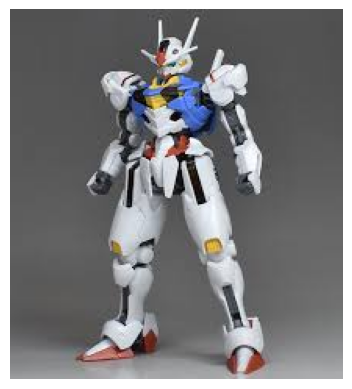

In [ ]:
plt.figure()
plt.axis("off")
plt.imshow(image)

### データ拡張

RandomResizedCrop
- 実行毎に異なるサイズ・比となる

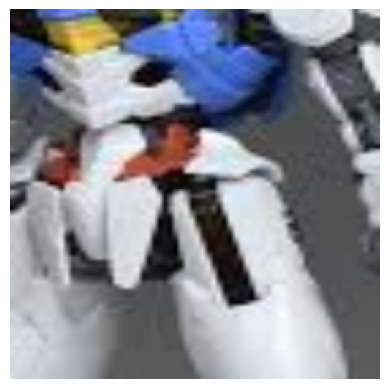

In [ ]:
t = transforms.RandomResizedCrop(224)
trans_image = t(image)
plt.figure()
plt.axis("off")
plt.imshow(trans_image)

RandomHorizontalFlip
- 2回実行で反転した

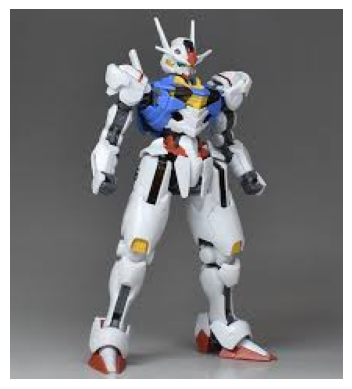

In [ ]:
t = transforms.RandomHorizontalFlip()
trans_image = t(image)
plt.figure()
plt.axis("off")
plt.imshow(trans_image)

Resize

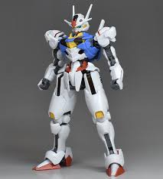

In [ ]:
t = transforms.Resize((int(torch.rand(1).item()*200+50), int(torch.rand(1).item()*200+50)))
trans_image = t(image)
trans_image

CenterCrop

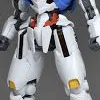

In [ ]:
t = transforms.CenterCrop(int(torch.rand(1).item()*200+50))
trans_image = t(image)
trans_image

### データ変換関数の作成

In [ ]:
batch_size = 64
num_epochs = 10
data_transforms = {
  'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'val': transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}

image_datasets = {x: datasets.ImageFolder("/content/drive/MyDrive/Colab Notebooks/gundam", data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                  batch_size=batch_size, shuffle=True, num_workers=4)
                  for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x])
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
acc_list = {x: [] for x in ['train', 'val']}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 訓練画像の可視化

torch.Size([64, 3, 224, 224]) torch.Size([64])


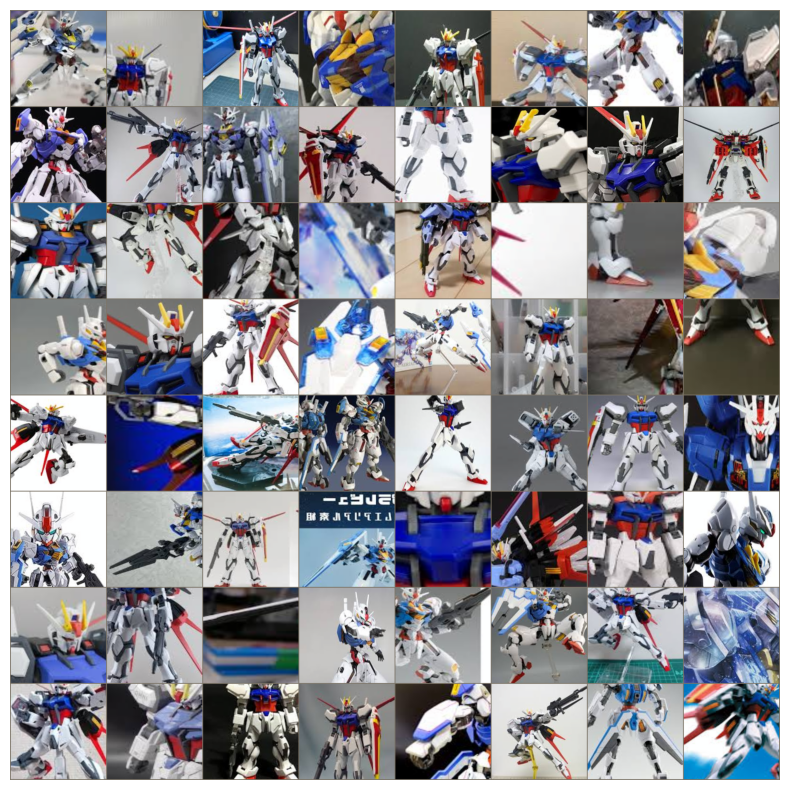

In [ ]:
def imshow(images, title=None, size=10):
  images = images.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  images = std * images + mean
  images = np.clip(images, 0, 1)
  plt.figure(figsize=(size,size))
  plt.imshow(images)
  plt.axis("off")
#  if title is not None:
#    plt.title(title)
images, classes = next(iter(dataloaders['train']))
print(images.size(), classes.size())
images = torchvision.utils.make_grid(images)
imshow(images, title=[class_names[x] for x in classes])

(7,3)．お前はなんだ．

1次元テンソルの表示

In [ ]:
classes

tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1])

### 訓練用関数の定義

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
  since = time.time()
  epoch_loss = 0.0
  epoch_acc = 0.0
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    # 各エポックで訓練+バリデーションを実行
    for phase in ['train', 'val']:
      if phase == 'train':
        scheduler.step()
        model.train()
      else:
        model.eval()
      running_loss = 0.0
      running_corrects = 0
      for data in dataloaders[phase]:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # 順伝播
        if phase == 'train':
          outputs = model(inputs)
        else:
          with torch.no_grad():
            outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1) #_は無視、データを捨てる
        loss = criterion(outputs, labels)
        if phase == 'train':
          loss.backward()
          optimizer.step()
        running_loss += loss.data.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss/dataset_sizes[phase]
      epoch_acc = running_corrects.item()/dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      # よい精度のモデルを自動的に保存する、よくあるテクニック
      acc_list[phase].append(epoch_acc)
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed / 60, time_elapsed % 60))
  print('Best val acc: {:.4f}'.format(best_acc))
  model.load_state_dict(best_model_wts) #もっともよいモデルを読み直す
  return model

## 実際に分類

### Fine-tuningによる分類

In [ ]:
model_ft = models.resnet18(pretrained=True)

# 最後のfc層を置き換える
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, 2) #3クラス分類なら2→3
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)
torch.save(model_ft.state_dict(), 'model_ft.pkl')
acc_list_ft = acc_list['val'].copy()
acc_list['val'] = []

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 57.7MB/s]


Epoch 0/9


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.6762 Acc: 0.6129
val Loss: 0.6694 Acc: 0.5968
Epoch 1/9
train Loss: 0.6629 Acc: 0.5806
val Loss: 0.6008 Acc: 0.6559
Epoch 2/9
train Loss: 0.6187 Acc: 0.6344
val Loss: 0.5207 Acc: 0.7258
Epoch 3/9
train Loss: 0.5146 Acc: 0.7419
val Loss: 0.4192 Acc: 0.8871
Epoch 4/9
train Loss: 0.4513 Acc: 0.8656
val Loss: 0.3413 Acc: 0.9409
Epoch 5/9
train Loss: 0.3894 Acc: 0.8925
val Loss: 0.2767 Acc: 0.9570
Epoch 6/9
train Loss: 0.3410 Acc: 0.9355
val Loss: 0.2720 Acc: 0.9624
Epoch 7/9
train Loss: 0.3347 Acc: 0.9301
val Loss: 0.2675 Acc: 0.9677
Epoch 8/9
train Loss: 0.3175 Acc: 0.9140
val Loss: 0.2625 Acc: 0.9677
Epoch 9/9
train Loss: 0.3217 Acc: 0.9140
val Loss: 0.2583 Acc: 0.9731
Training complete in 0m 26s
Best val acc: 0.9731


### 一般的な転移学習による分類

In [ ]:
# 訓練済みResNet18をロード
model_conv = torchvision.models.resnet18(pretrained=True)

# 全パラメータを固定
for param in model_conv.parameters():
  param.requires_grad = False

# 最後のfc層を置き換える(requires_grad=Trueでありパラメータ更新の対象)
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2) #3クラス分類なら2→3
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                       exp_lr_scheduler, num_epochs=num_epochs)
acc_list_tr = acc_list['val'].copy()
acc_list['val'] = []

Epoch 0/9
train Loss: 0.6926 Acc: 0.5753
val Loss: 0.6740 Acc: 0.6183
Epoch 1/9
train Loss: 0.6562 Acc: 0.5914
val Loss: 0.6756 Acc: 0.6237
Epoch 2/9
train Loss: 0.6248 Acc: 0.6505
val Loss: 0.6266 Acc: 0.6828
Epoch 3/9
train Loss: 0.5959 Acc: 0.6774
val Loss: 0.5752 Acc: 0.7312
Epoch 4/9
train Loss: 0.5745 Acc: 0.7258
val Loss: 0.5352 Acc: 0.7742
Epoch 5/9
train Loss: 0.5292 Acc: 0.7957
val Loss: 0.5110 Acc: 0.7581
Epoch 6/9
train Loss: 0.5278 Acc: 0.7312
val Loss: 0.5030 Acc: 0.7688
Epoch 7/9
train Loss: 0.4909 Acc: 0.8011
val Loss: 0.4974 Acc: 0.7796
Epoch 8/9
train Loss: 0.4816 Acc: 0.8333
val Loss: 0.4913 Acc: 0.8011
Epoch 9/9
train Loss: 0.4901 Acc: 0.8118
val Loss: 0.4854 Acc: 0.8065
Training complete in 0m 21s
Best val acc: 0.8065


### 分類結果の表示

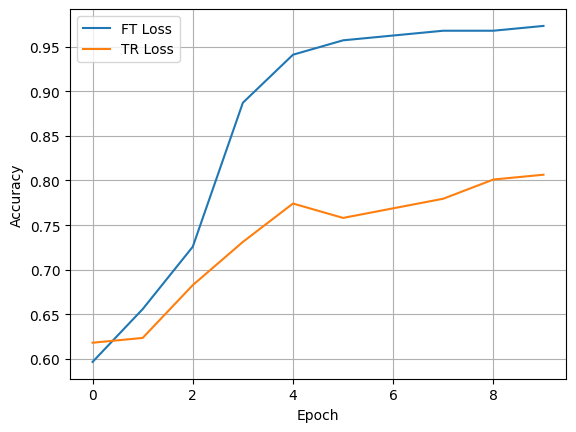

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(num_epochs), acc_list_ft, label='FT Loss')
plt.plot(range(num_epochs), acc_list_tr, label='TR Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

Fine-tuning:
- training time : 26[s]
- accuracy : 0.9731


一般:
- training time : 21[s]
- accuracy : 0.8056

5秒差ながら，Fine-tuningの方がはるかに精度が良い．

可視化

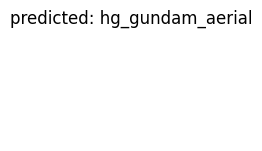

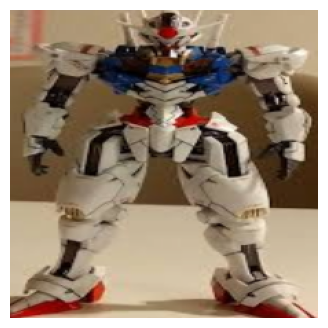

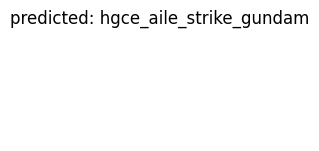

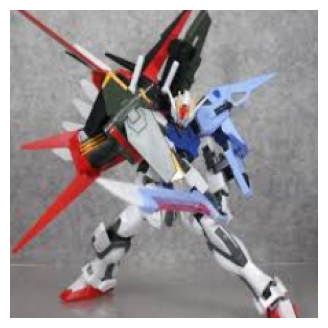

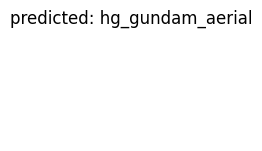

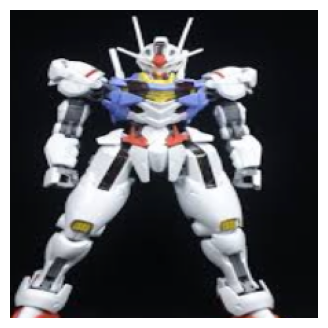

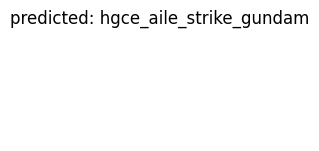

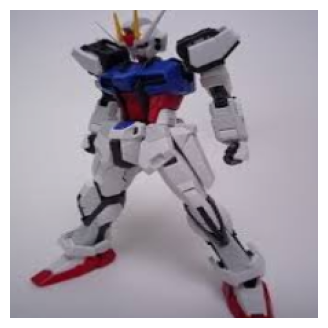

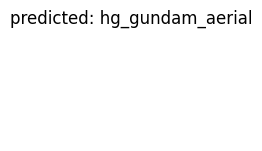

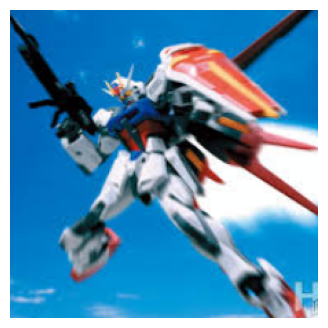

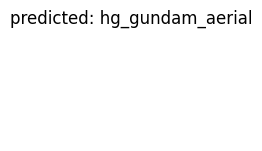

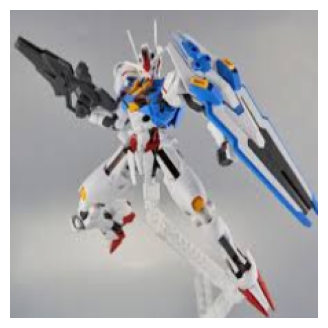

In [ ]:
model_ft.load_state_dict(torch.load('model_ft.pkl', map_location=lambda storage, loc: storage))
def visualize_model(model, num_images=6):
  images_so_far = 0
  fig = plt.figure()
  model.eval()
  for i, data in enumerate(dataloaders['val']):
    inputs, labels = data
    inputs = inputs.cuda().to(device)
    inputs.requires_grad = False
    labels = labels.cuda().to(device)
    labels.requires_grad = False
    with torch.no_grad():
      outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)
    for j in range(inputs.size()[0]):
      images_so_far += 1
      plt.subplot(num_images // 2, 2, images_so_far)
      plt.axis('off')
      plt.title('predicted: {}'.format(class_names[preds[j]]))
      imshow(inputs.cpu().data[j], size=4)
      plt.show()
      if images_so_far == num_images:
        return
visualize_model(model_ft)

## いい感じ，と思いきや，おっと．．？(4つ目)